## 1. Improt Library
___

In [1]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

## Tensorflow Setting
import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split

import warnings 
import albumentations as albu
warnings.filterwarnings('ignore')

## GPU Settings
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None

2024-08-17 03:24:57.502277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 03:24:57.502418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 03:24:57.663169: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version:  2.15.0
Using 2 GPUs


## 2. Road and Read Data
___

In [2]:
mask_name = os.listdir('/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/masks/')

df = pd.DataFrame(mask_name, columns=['Mask Index'])

In [3]:
%%time

mapping_path = {os.path.basename(x): x for x in glob('../input/*/Lung Segmentation/masks/*.png')}

df['mask path'] = df['Mask Index'].map(mapping_path)
df['Mask Index'] = df['Mask Index'].apply(lambda x: x.replace('.png','_mask.png') if not 'mask'  in x else x)

df['Image Index'] = df['Mask Index'].str.replace('_mask', '')

CPU times: user 9.78 ms, sys: 0 ns, total: 9.78 ms
Wall time: 16.7 ms


In [4]:
mapping_path = {os.path.basename(x): x for x in glob('../input/*/Lung Segmentation/CXR_png/*.png')}

df['path'] = df['Image Index'].map(mapping_path)

In [5]:
print('Shape of DataFrame: ', df.shape)
print(display(df))

Shape of DataFrame:  (704, 4)


,Mask Index,mask path,Image Index,path
0,CHNCXR_0300_0_mask.png,../input/chest-xray-masks-and-labels/Lung Segm...,CHNCXR_0300_0.png,../input/chest-xray-masks-and-labels/Lung Segm...
1,CHNCXR_0083_0_mask.png,../input/chest-xray-masks-and-labels/Lung Segm...,CHNCXR_0083_0.png,../input/chest-xray-masks-and-labels/Lung Segm...
2,CHNCXR_0094_0_mask.png,../input/chest-xray-masks-and-labels/Lung Segm...,CHNCXR_0094_0.png,../input/chest-xray-masks-and-labels/Lung Segm...
3,CHNCXR_0597_1_mask.png,../input/chest-xray-masks-and-labels/Lung Segm...,CHNCXR_0597_1.png,../input/chest-xray-masks-and-labels/Lung Segm...
4,MCUCXR_0017_0_mask.png,../input/chest-xray-masks-and-labels/Lung Segm...,MCUCXR_0017_0.png,../input/chest-xray-masks-and-labels/Lung Segm...
...,...,...,...,...
699,CHNCXR_0655_1_mask.png,../input/chest-xray-masks-and-labels/Lung Segm...,CHNCXR_0655_1.png,../input/chest-xray-masks-and-labels/Lung Segm...
700,CHNCXR_0006_0_mask.png,../input/chest-xray-masks-and-labels/Lung Segm...,CHNCXR_0006_0.png,../input/chest-xray-masks-and-labels/Lung Segm...
701,MCUCXR_0108_1_mask.png,../input/chest-xray-masks-and-labels/Lung Segm...,MCUCXR_0108_1.png,../input/chest-xray-masks-and-labels/Lung Segm...
702,CHNCXR_0050_0_mask.png,../input/chest-xray-masks-and-labels/Lung Segm...,CHNCXR_0050_0.png,../input/chest-xray-masks-and-labels/Lung Segm...


None


#### Split

In [6]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=True, random_state=42)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## 3. Build DataGenerator
___

In [7]:
import albumentations as albu

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, preprocess=None, augment=False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocess = preprocess
        self.augment = augment
        self.on_epoch_end()
        
    def __len__(self):
        # Drop_Last = False
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X,y = self.__data_generation(indexes)
        if self.augment: X, y = self.__augment(X, y)  
        return X,y
    
    def __data_generation(self, indexes):    
        X = np.zeros((len(indexes),512,512,3), dtype='float32')
        y = np.zeros((len(indexes),512,512,1), dtype='float32') 
        
        for j,i in enumerate(indexes):
            ## Image
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('RGB')
            img = img.resize((512,512), Image.Resampling.LANCZOS)
            img = np.array(img)   
            
            X[j,] = img
            if self.preprocess != None: X = self.preprocess(X)
            
            ## Mask
            mask_path = row['mask path']
            mask = Image.open(mask_path)
            mask = mask.resize((512,512), Image.Resampling.LANCZOS)
            mask = np.array(mask)
            
            mask = mask / 255
                
            y[j,:,:,0] = mask
                
        return X, y
    
    def __augment(self, img_batch, mask_batch):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),  
            albu.Rotate(limit=5, p=0.5),
        ])
        for i in range(img_batch.shape[0]):
            augmented = composition(image=img_batch[i,], mask=mask_batch[i,])
  
            img_batch[i,] = augmented['image']
            mask_batch[i,] = augmented['mask']
        return img_batch, mask_batch

### Display DataGenerator

In [8]:
def mask2contour(mask, width=5):
    h = mask.shape[0]
    w = mask.shape[1]
    
    mask2 = np.concatenate([mask[:,width:], np.zeros((h,width))], axis=1)
    mask2 = np.logical_xor(mask, mask2)
    mask3 = np.concatenate([mask[width:,:], np.zeros((width,w))], axis=0)
    mask3 = np.logical_xor(mask,mask3)

    return np.logical_or(mask2,mask3)

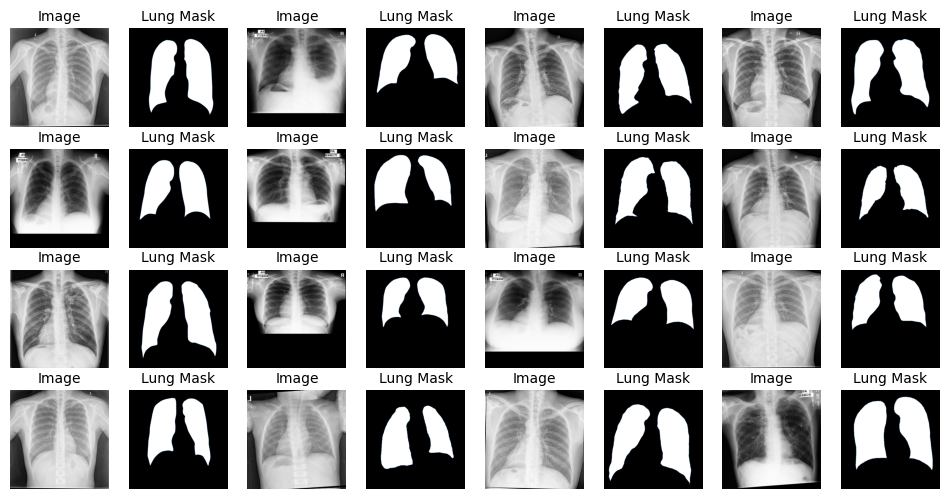

In [9]:
BATCH_IDX = 0

gen = DataGenerator(df_train, batch_size=32, shuffle=False, preprocess=None, augment=True)


for batch_idx, (X,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for i in range(16):
        plt.subplot(4,8, 2*i+1)
        img = X[i,]
        img = img.astype('uint8')
        plt.imshow(img)
        plt.title('Image', size=10)
        plt.axis('off')
        plt.subplot(4,8, 2*i+2)
        plt.title('Lung Mask', size=10)
        mask = y[i]
        plt.imshow(mask, cmap='bone')
        plt.axis('off')
    
    if BATCH_IDX == batch_idx: break
    plt.tight_layout()  
    plt.show()

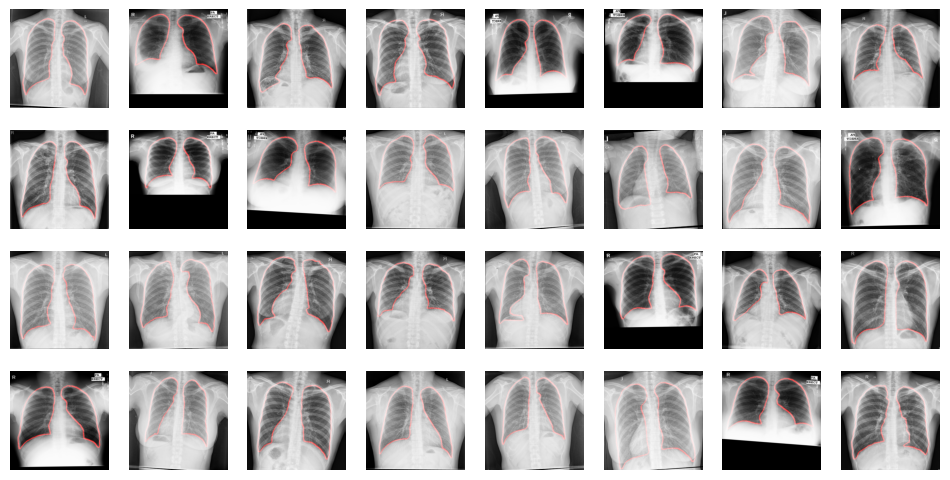

In [10]:
BATCH_IDX = 0

gen = DataGenerator(df_train, batch_size=32, shuffle=False, preprocess=None, augment=True)


for batch_idx, (X,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for i in range(32):
        plt.subplot(4,8, i+1)
        img = X[i,]
        img = img.astype('uint8')
        mask = y[i,:,:,0]
        mask = mask2contour(mask)
        
        img[mask>0,0] = 255 
        plt.imshow(img)
        plt.axis('off')
    
    if BATCH_IDX == batch_idx: break
    plt.tight_layout()  
    plt.show()

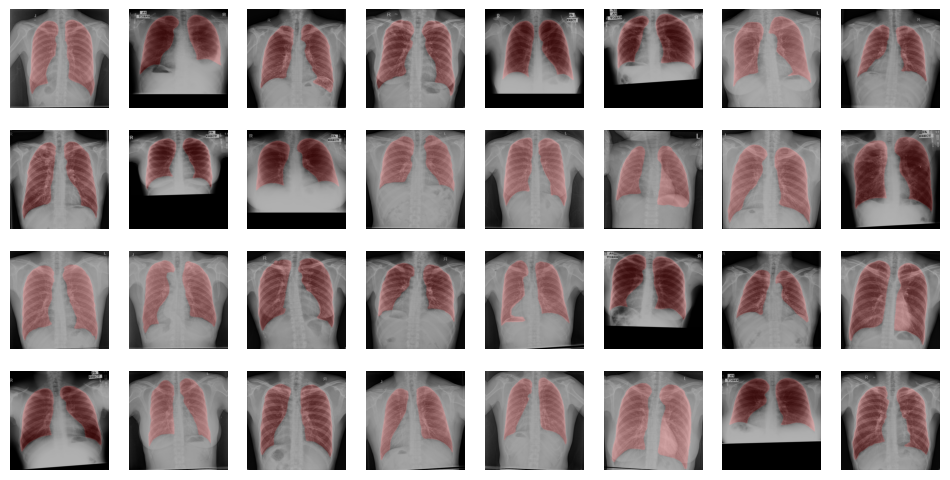

In [11]:
BATCH_IDX = 0

gen = DataGenerator(df_train, batch_size=32, shuffle=False, preprocess=None, augment=True)


for batch_idx, (X,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for i in range(32):
        plt.subplot(4,8, i+1)
        img = X[i,]
        img = img.astype('uint8')
        tmp = y[i,:,:,0]
        mask = cv2.cvtColor(y[i,], cv2.COLOR_GRAY2RGB)
        mask = (mask * 255).astype('uint8')
        mask[tmp>0,0] = 150
        mask[tmp>0,1] = 0
        mask[tmp>0,2] = 0
        
        img = cv2.addWeighted(img, 0.7, mask, 0.3, 0)
         
        plt.imshow(img)
        plt.axis('off')
    
    if BATCH_IDX == batch_idx: break
    plt.tight_layout()  
    plt.show()

## 4. Build Segmentation Model
___

In [12]:
!pip install -q -U segmentation_models

In [13]:
os.environ["SM_FRAMEWORK"] = 'tf.keras'
import segmentation_models

Segmentation Models: using `tf.keras` framework.


In [14]:
def dice(y_true, y_pred, threshold = 0.5, smooth=1):
    
    y_pred = (y_pred >= threshold).astype('float32')
    
    true_sum = np.sum(y_true)
    pred_sum = np.sum(y_pred)
    
    intersection = np.sum(y_true * y_pred)
    dice = (2 * intersection + smooth) / (true_sum + pred_sum + smooth)
    
    return dice 

In [15]:
from segmentation_models import Unet
preprocess = segmentation_models.get_preprocessing('efficientnetb1')

def build_model():
    
    unet_model = Unet('efficientnetb1', input_shape=(512,512,3), classes=1, activation='sigmoid')
    
    ## Freezing Layers(10%)
    for layer in unet_model.layers[:len(unet_model.layers)//10]:
        layer.trainable=False

    dice_loss = segmentation_models.losses.DiceLoss()
    dice_metric = segmentation_models.metrics.FScore(threshold=0.5)

    opt = optimizers.Adam(learning_rate=1e-4)
    
    unet_model.compile(optimizer=opt, loss=dice_loss, metrics=[dice_metric])
    
    return unet_model

## 5. Train UNet Model
___

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

EPOCHS = 10

es = EarlyStopping(monitor='val_dice_metric', mode='max', patience=10)

lr = ReduceLROnPlateau(monitor = 'val_dice_metric', factor = 0.1, patience = 2, min_delta = 0.01,
                              mode='max',verbose=1)

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, val_idx) in enumerate(kf.split(df_train)):  
    df_train.loc[val_idx,'fold'] = i

In [18]:
all_history = defaultdict(list)
all_oof = []
 
for i in range(1):
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(df_train[df_train['fold'] != i], batch_size=8, shuffle=True, preprocess=preprocess, augment=False)
    valid_gen = DataGenerator(df_train[df_train['fold'] == i], batch_size=16, shuffle=False, preprocess=preprocess, augment=False)
    
    print(f'### train size {len(df_train[df_train["fold"] != i])}, valid size {len(df_train[df_train["fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'UNet_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid Dice'].append(history.history['val_f1-score'])
        all_history['Train Dice'].append(history.history['f1-score'])
    else:
        model.load_weights(f'{LOAD_MODELS_FROM}UNet_f{i}.weights.h5')
    
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    
    del model, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)

#########################
### Fold 1
### train size 506, valid size 127
#########################
27164032/27164032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


2024-08-17 03:28:37.345845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_2258/cond/StatefulPartitionedCall/functional_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 ━━━━━━━━━━━━━━━━━━━━ 510s 4s/step - f1-score: 0.4910 - loss: 0.5734 - val_f1-score: 3.5475e-05 - val_loss: 0.7361 - learning_rate: 1.0000e-04
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - f1-score: 0.7836 - loss: 0.3607 - val_f1-score: 1.8544e-11 - val_loss: 0.5532 - learning_rate: 1.0000e-04
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - f1-score: 0.8059 - loss: 0.2942 - val_f1-score: 0.6339 - val_loss: 0.4536 - learning_rate: 1.0000e-04
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - f1-score: 0.8136 - loss: 0.2540 - val_f1-score: 0.6158 - val_loss: 0.4171 - learning_rate: 1.0000e-04
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - f1-score: 0.8198 - loss: 0.2302 - val_f1-score: 0.7265 - val_loss: 0.3887 - learning_rate: 1.0000e-04
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - f1-score: 0.8276 - loss: 0.2092 - val_f1-score: 0.6905 - val_loss: 0.4283 - learning_rate: 1.0000e-04
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - f1-score: 0.8175 - l

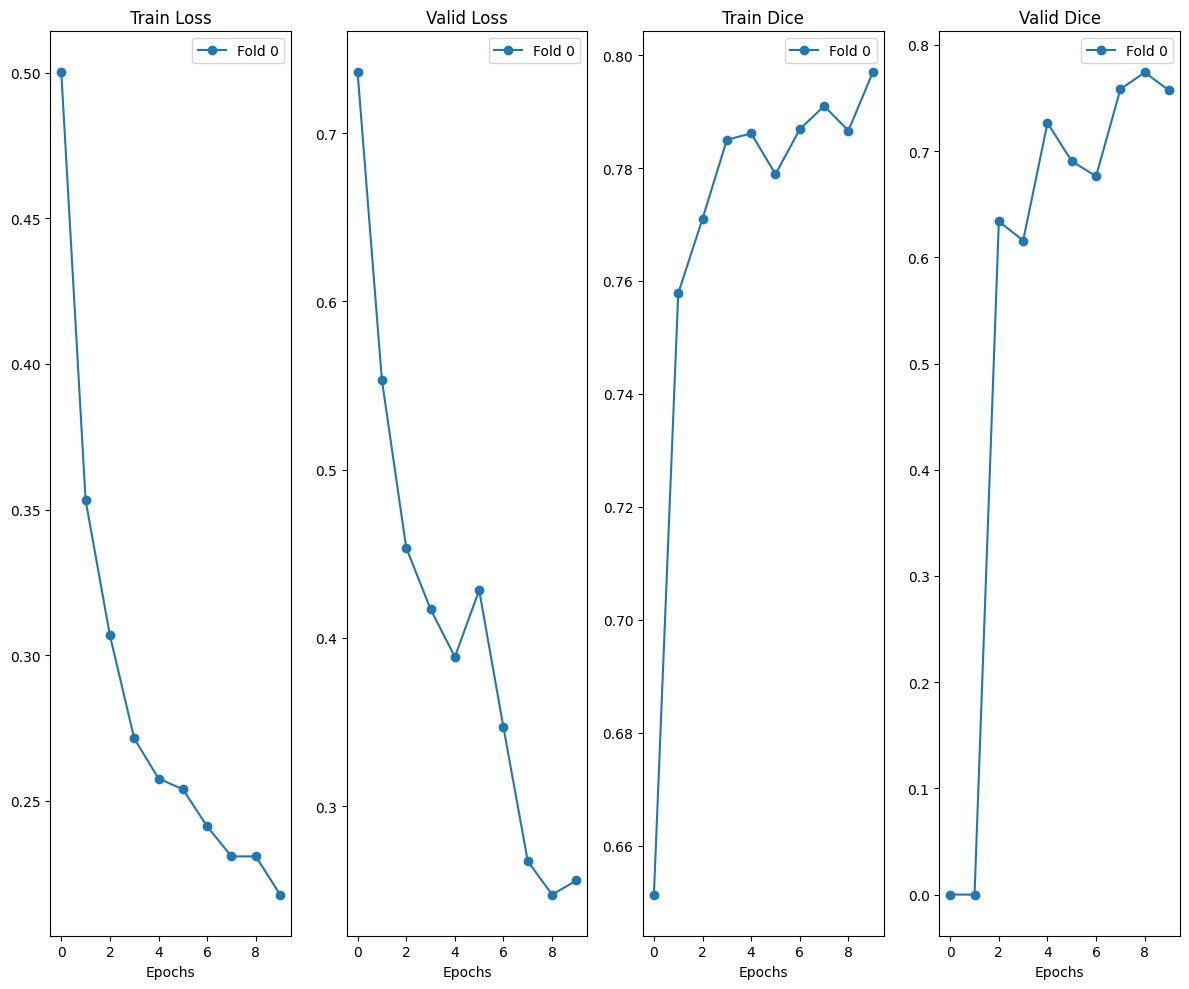

In [19]:
if LOAD_MODELS_FROM is None:
    plt.figure(figsize=(12,10))
    plt.subplot(1,4,1)
    plt.title('Train Loss')
    for fold, i in enumerate(all_history['Train Loss']):
        plt.plot(i,'-o', label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1,4,2)
    plt.title('Valid Loss')
    for fold, i in enumerate(all_history['Valid Loss']):
        plt.plot(i, '-o', label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1,4,3)
    plt.title('Train Dice')
    for fold, i in enumerate(all_history['Train Dice']):
        plt.plot(i, '-o', label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(1,4,4)
    plt.title('Valid Dice')
    for fold, i in enumerate(all_history['Valid Dice']):
        plt.plot(i, '-o', label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [20]:
all_true = np.zeros((len(df_train), 512,512,1), dtype='float32')

for i in tqdm(range(len(df_train))):
    row = df_train.iloc[i]
    mask_path = row['mask path']
    mask = Image.open(mask_path)
    mask = mask.resize((512,512), Image.Resampling.LANCZOS)
    mask = np.array(mask)
                
    all_true[i,:,:,0] = mask/255

100%|██████████| 633/633 [01:10<00:00,  8.93it/s]


In [21]:
preds = []
model = build_model()

train_gen = DataGenerator(df_train, batch_size=32, shuffle=False, preprocess=preprocess, augment=False)
    
for i in range(1):
    print(f'Fold {i+1}') 
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}UNet_f{i}.weights.h5')
    else: 
        model.load_weights(f'UNet_f{i}.weights.h5')
    
    pred = model.predict(train_gen, verbose=1) 
    
preds.append(pred)
pred = np.mean(preds,axis=0)
all_oof = pred

Fold 1


2024-08-17 04:17:18.966045: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,160,256,256]{3,2,1,0}, f32[32,160,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-17 04:17:20.227734: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.261799912s
Trying algorithm eng0{} for conv (f32[32,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,160,256,256]{3,2,1,0}, f32[32,160,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-17 04:17:26.603021: E external/local_xla/

 1/20 ━━━━━━━━━━━━━━━━━━━━ 40:23 128s/step

I0000 00:00:1723868278.214045      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/20 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step

2024-08-17 04:23:07.571968: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[25,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,160,256,256]{3,2,1,0}, f32[32,160,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-17 04:23:08.379647: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.807795197s
Trying algorithm eng0{} for conv (f32[25,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,160,256,256]{3,2,1,0}, f32[32,160,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-17 04:23:15.131996: E external/local_xla/

20/20 ━━━━━━━━━━━━━━━━━━━━ 470s 18s/step


In [22]:
score = dice(all_true, all_oof, threshold=0.5)
    
print("=> Dice Score is: ", score)

=> Dice Score is:  0.7471444631206811


## 6. Inference

In [23]:
y_test = np.zeros((len(df_test), 512,512,1), dtype='float32')

for i in tqdm(range(len(df_test))):
    row = df_test.iloc[i]
    mask_path = row['mask path']
    mask = Image.open(mask_path)
    mask = mask.resize((512,512), Image.Resampling.LANCZOS)
    mask = np.array(mask)
                
    y_test[i,:,:,0] = mask/255

100%|██████████| 71/71 [00:08<00:00,  8.52it/s]


In [24]:
preds = []

test_gen = DataGenerator(df_test, batch_size=16, shuffle=False, preprocess=preprocess, augment=False)
    
for i in range(1):
    model = build_model()
    if LOAD_MODELS_FROM is None: 
        model.load_weights(f'UNet_f{i}.weights.h5')
    else:
        model.load_weights(f'{LOAD_MODELS_FROM}UNet_f{i}.weights.h5')
     
    pred = model.predict(test_gen, verbose=1)
    preds.append(pred)
    del model, pred

test_pred = np.mean(preds, axis=0)

2024-08-17 04:25:01.722728: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,160,256,256]{3,2,1,0}, f32[32,160,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-17 04:25:01.916699: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.194107276s
Trying algorithm eng0{} for conv (f32[16,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,160,256,256]{3,2,1,0}, f32[32,160,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-17 04:25:06.695500: E external/local_xla/

5/5 ━━━━━━━━━━━━━━━━━━━━ 130s 14s/step


In [25]:
dice_score = dice(y_test, test_pred, threshold=0.5)

print(dice_score)

0.7155646476464188


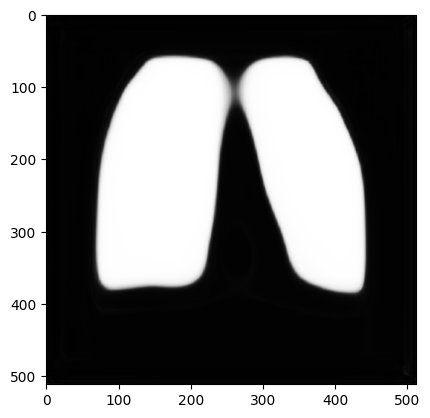

In [26]:
plt.imshow(test_pred[10], cmap='gray')